<a href="https://colab.research.google.com/github/jgermanob/DeepLearning/blob/master/T01/AP_T01_Ej03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Regresión lineal con pytorch
Entrena y evalúa un modelo de regresión lineal para el conjunto de datos de calificaciones que
considere los dos atributos de entrada.

## Especificaciones
* Grafica los datos en 3D.
* Realiza la definición de la arquitectura usando tanto la interfaz de alto como la de medio nivel.
* Prueba distintos valores para los hiperparámetros.

In [1]:
!pip3 install torchinfo

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import random
import plotly.express as px
import plotly.graph_objects as go
from torchinfo import summary
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

### Lectura de datos

In [4]:
url = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2022-1/data/califs.csv'

In [5]:
df = pd.read_csv(url)

In [6]:
df.head()

,prev,horas,calif
0,5.6,8.2,5.1
1,6.7,9.3,5.9
2,5.1,10.0,5.4
3,5.7,10.4,6.5
4,7.1,10.4,6.7


In [7]:
X = df[['prev', 'horas']].to_numpy(dtype='float32')
y = df['calif'].to_numpy(dtype='float32').reshape(-1,1)

In [8]:
X = torch.tensor(X)
y = torch.tensor(y)

In [9]:
ds = TensorDataset(X, y)

### Cargador de datos

In [10]:
def build_dl(dataset, batch_size=16):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Gráfica de datos en 3D

In [11]:
fig = px.scatter_3d(df, x='prev', y='horas', z='calif')
fig.show()

In [12]:
def plot_solution(df, model):
    g = 100
    X = df[['prev', 'horas']].to_numpy(dtype='float32')
    x_1 = np.linspace((X[:,0].min()-1), (X[:,0].max()+1), g, dtype=np.float32)
    x_2 = np.linspace((X[:,1].min()-1), (X[:,1].max()+1), g, dtype=np.float32)
    
    X1, X2 = np.meshgrid(x_1, x_2)
    X_mesh = np.zeros((g**2,2), dtype=np.float32)
    X_mesh[:,0] = X1.flatten()
    X_mesh[:,1] = X2.flatten()
    Y = model(torch.tensor(X_mesh)).detach().numpy()
    y_pred = model(torch.tensor(X)).detach().numpy().reshape(50,)
    fig = go.Figure(data=[go.Surface(z=Y.reshape((g,g)), x=X1, y=X2)])

    x = df['prev'].to_numpy()
    y = df['horas'].to_numpy()
    z = df['calif'].to_numpy()

    fig.add_scatter3d(x=x, y=y, z=z, mode='markers')
    fig.show()

### Definición de arquitectura con API de medio nivel nivel

In [13]:
class Linear_regression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Linear_regression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out

### Definición de arquitectura con API de alto nivel

In [14]:
def build_model(input_dim, output_dim):
    return torch.nn.Sequential(torch.nn.Linear(input_dim, output_dim))

### Función para realizar entrenamiento

In [15]:
def train_model(model, dl, learning_rate, epochs):
    opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

    for e in range(epochs):
      loss_hst = []
      for x, y_true in dl: 
        output = model(x)
        loss = F.mse_loss(output, y_true)
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_hst.append(loss.item()*100)
      
      loss = np.mean(loss_hst)
      #print('Epoch: {}\tLoss = {}'.format(e, loss))
    
    return model

### Función de entrenamiento y evaluación con diferentes hiperparámetros

In [16]:
def get_model(model_type, input_dim, output_dim):
  if model_type == 'medium':
    model = Linear_regression(input_dim, output_dim)
  else:
    model = build_model(input_dim, output_dim)
  return model

In [17]:
def train_evaluate(model_type, ds, hparams, df, input_dim=2, output_dim=1):
  hp_batch_size = hparams.get('batch_size',[16])
  hp_learning_rate = hparams.get('learning_rate', [1e-5])
  hp_epochs = hparams.get('epochs', [200])

  x = Variable(torch.from_numpy(df[['prev','horas']].to_numpy())).float()
  y = Variable(torch.from_numpy(df['calif'].to_numpy())).float()
  
  for i in range(len(hp_batch_size)):
    for j in range(len(hp_learning_rate)):
      error = []
      for k in range(len(hp_epochs)):
        model = get_model(model_type, input_dim, output_dim)
        dl = build_dl(ds, batch_size=hp_batch_size[i])
        m = train_model(model, dl, hp_learning_rate[j], hp_epochs[k])
        with torch.no_grad():
          y_pred = m(x)
        mse = mean_squared_error(y, y_pred)
        error.append(mse)

      plt.figure()
      plt.grid()
      plt.plot(hp_epochs, error)
      plt.title('Batch size = {}\nLearning rate = {}'.format(hp_batch_size[i], hp_learning_rate[j]))
      plt.xticks(hp_epochs, hp_epochs)
      plt.xlabel('Epochs')
      plt.ylabel('MSE')
      plt.show()




### Hiperparámetros

In [18]:
hparams = {'batch_size':[8,16,32], 'learning_rate':[1e-3, 1e-4, 1e-5, 1e-6, 1e-7], 'epochs':[10, 100, 200, 300]}

Se prueban distintos hiperparámetros para el tamaño del lote, la tasa de aprendizaje y el número de epocas para entrenar el modelo. Para evaluar el modelo se utiliza el error cuadrático medio, el cual se define como:
$$ MSE = \frac{1}{n} \sum_{i=1}^{n}{(\hat{y_i} - y_i)^2} $$

Después de analizar las gráficas se seleccionan los valores para los hiperparámetros que tuvieron mejor rendimiento.

### Entrenamiento de modelo construido mediante API de medio nivel

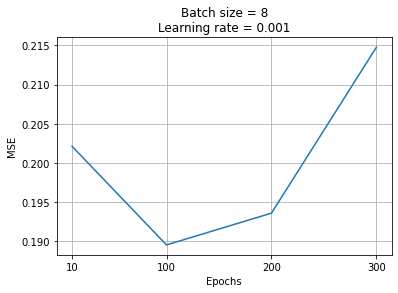

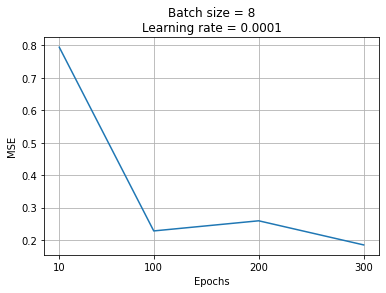

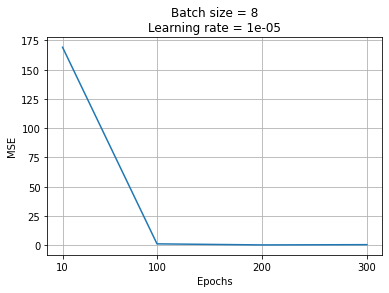

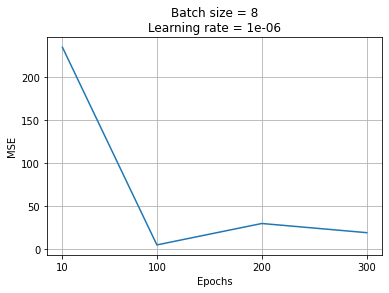

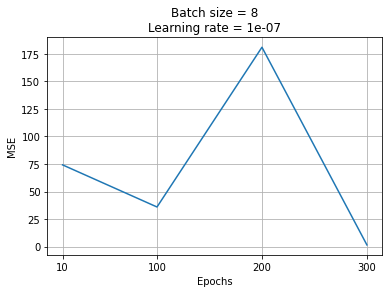

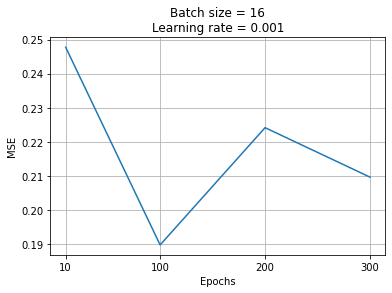

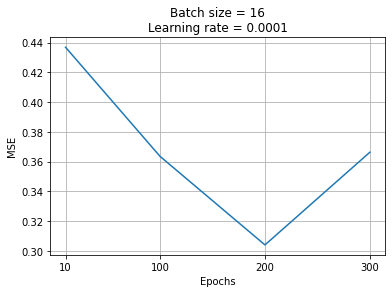

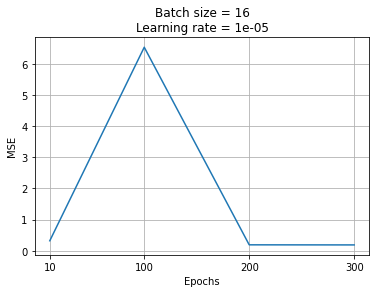

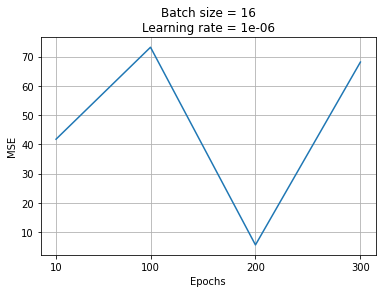

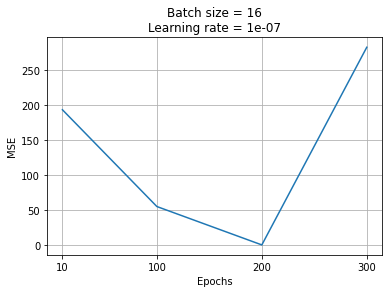

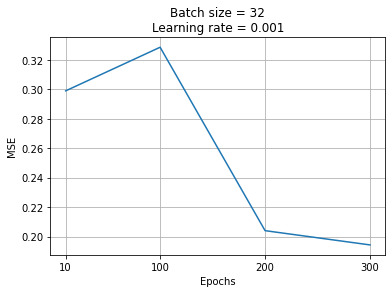

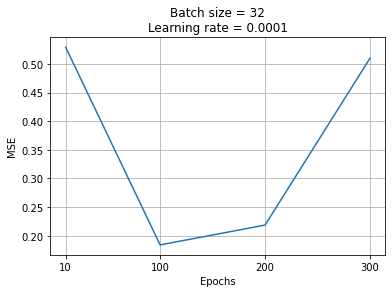

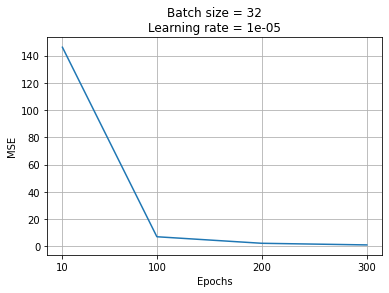

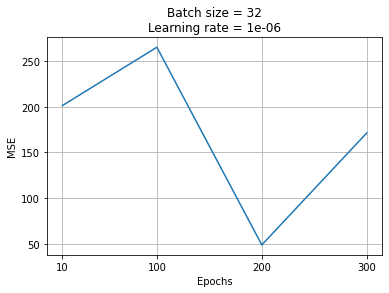

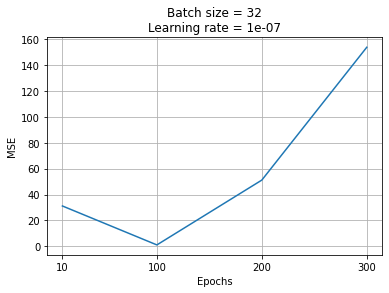

In [19]:
set_seed()
train_evaluate('medium', ds, hparams, df)

Se seleccionaron los siguientes hiperparámetros:
* Tamaño de lote = 8
* Tasa de aprendizaje = 0.001
* Epocas = 100

In [20]:
set_seed()
dl = build_dl(ds, batch_size=8)
model_ml = Linear_regression(input_dim = 2, output_dim = 1)

In [21]:
summary(model_ml)

Layer (type:depth-idx)                   Param #
Linear_regression                        --
├─Linear: 1-1                            3
Total params: 3
Trainable params: 3
Non-trainable params: 0

In [22]:
train_model(model_ml, dl,learning_rate=0.001, epochs=100)

Linear_regression(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

In [23]:
plot_solution(df, model_ml)

### Entrenamiento de modelo construido mediante API de alto nivel

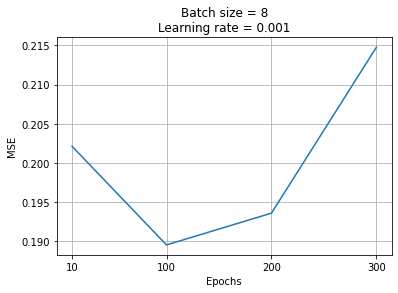

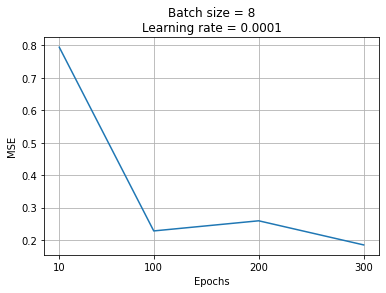

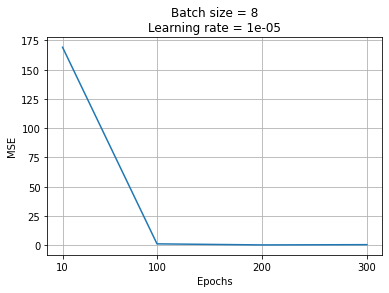

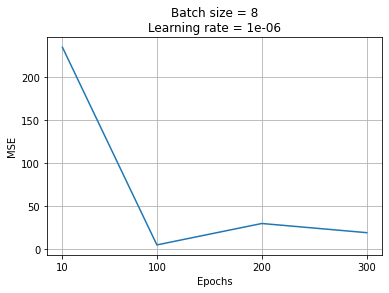

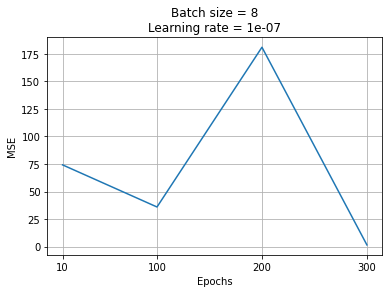

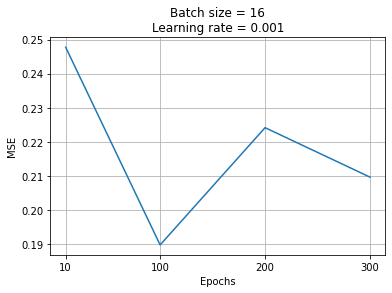

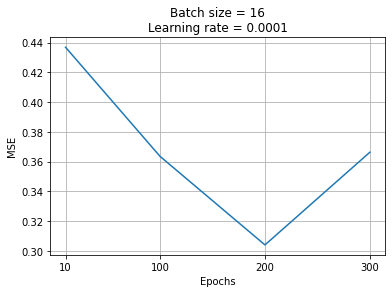

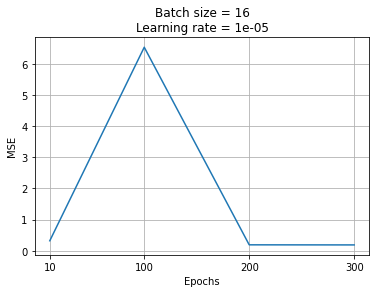

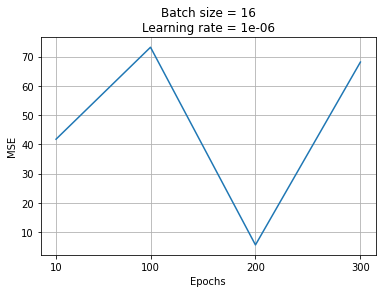

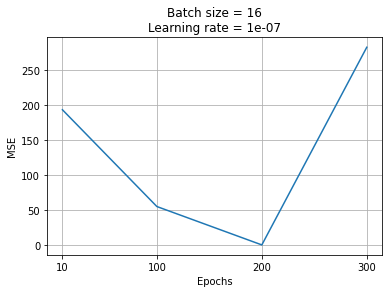

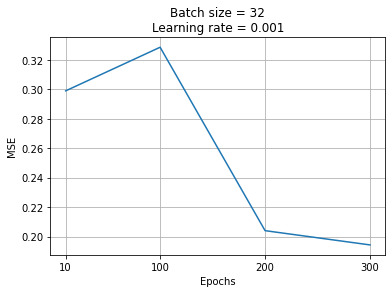

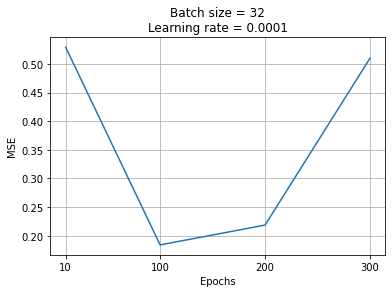

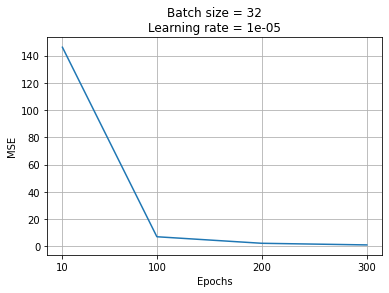

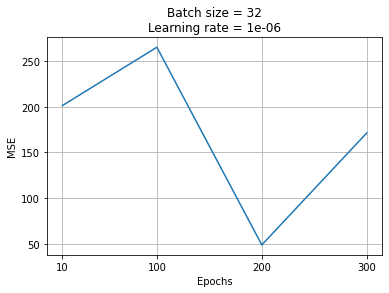

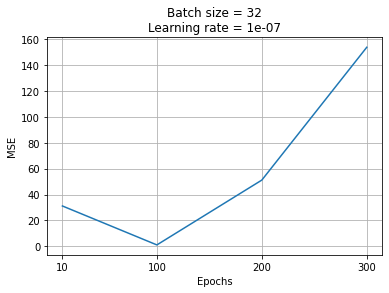

In [24]:
set_seed()
train_evaluate('high', ds, hparams, df)

Se seleccionaron los siguientes hiperparámetros:
* Tamaño de lote = 8
* Tasa de aprendizaje = 0.001
* Epocas = 100

In [25]:
set_seed()
model_hl = build_model(input_dim = 2, output_dim = 1)
dl = build_dl(ds, batch_size=8)

In [26]:
summary(model_hl)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            3
Total params: 3
Trainable params: 3
Non-trainable params: 0

In [27]:
train_model(model_hl, dl,learning_rate=0.001, epochs=100)

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)

In [28]:
plot_solution(df, model_hl)